__<h1>XGBOOST, ADA_BOOST & RANDOM FOREST</h1>__

___KEY NOTES IN VERSION 3___
- in this notebook, we aim to determine if the home team wins, 1, or doesn't 0. (loss or draw)
- I used the random forest and adaptive boosting models using their default parameters
- performance evaluated with k-fold cv
- outliers removed

In [1]:
import pandas as pd, numpy as np, seaborn as sns, glob, time, os, matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

In [2]:
os.chdir('/Users/ERIA/Desktop/MATCH_DATA/')

The cell below shows how the glob module is used to gather file names of the same type into a list. In this case, I collected all csv files in the /Users/ERIA/Desktop/MATCH_DATA/ directory

In [3]:
csv_files=glob.glob('*.csv')
len(csv_files)

14

all the files are then concatanated together along the rows (axis=0) to form one collection df

In [4]:
count=0
for file in tqdm(csv_files):
    
    if count ==0:
        df=pd.read_csv(file)
        count+=1
        continue
    else:
        file=pd.read_csv(file)
        df=pd.concat([df,file], axis=0)
        count+=1
df.shape

100%|██████████| 14/14 [00:00<00:00, 122.01it/s]


(6468, 6)

__<h2>DATA CLEANING</h2>__

In [5]:
df.head()

,Unnamed: 0,home,draw,away,h,a
0,0,3.92,3.94,1.91,0.0,1.0
1,1,2.17,3.58,3.60,1.0,1.0
2,2,1.85,3.94,4.52,1.0,0.0
3,3,1.43,5.25,8.00,2.0,1.0
4,4,1.16,9.40,19.00,9.0,0.0


In [6]:
df.drop(columns=['Unnamed: 0'],inplace=True, axis=1)
df.head()

,home,draw,away,h,a
0,3.92,3.94,1.91,0.0,1.0
1,2.17,3.58,3.60,1.0,1.0
2,1.85,3.94,4.52,1.0,0.0
3,1.43,5.25,8.00,2.0,1.0
4,1.16,9.40,19.00,9.0,0.0


In [7]:
df.isna().sum()

home      0
draw      0
away      0
h       109
a       109
dtype: int64

In [8]:
df.dropna(inplace=True)
df.isna().sum()

home    0
draw    0
away    0
h       0
a       0
dtype: int64

In [9]:
df.dtypes

home    object
draw    object
away    object
h       object
a       object
dtype: object

The data contains hyphens '-' for matches that didn't have odds by the time of collection. These records have to be dropped. I replace hyphens with nulls which I subsquently drop too as shown below 

In [10]:
df.replace(to_replace='-', value=np.nan, inplace=True)
df.isna().sum()

home    1483
draw    1564
away    1566
h         13
a         13
dtype: int64

In [11]:
df.dropna(inplace=True)
df.isna().sum()

home    0
draw    0
away    0
h       0
a       0
dtype: int64

All features converted to float

In [12]:
df=df.astype('float')
df.dtypes

home    float64
draw    float64
away    float64
h       float64
a       float64
dtype: object

In [13]:
df.head()

,home,draw,away,h,a
0,3.92,3.94,1.91,0.0,1.0
1,2.17,3.58,3.60,1.0,1.0
2,1.85,3.94,4.52,1.0,0.0
3,1.43,5.25,8.00,2.0,1.0
4,1.16,9.40,19.00,9.0,0.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4781 entries, 0 to 278
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   home    4781 non-null   float64
 1   draw    4781 non-null   float64
 2   away    4781 non-null   float64
 3   h       4781 non-null   float64
 4   a       4781 non-null   float64
dtypes: float64(5)
memory usage: 224.1 KB


__<h3>creating the target variable, result</h3>__
for the home team win, we classify that as 1. A draw or win for the away team, 0

In [15]:
#aiming
df['result']=np.where(df['h']==df['a'],0, np.where(df.h<df.a,0,1) )

df.head()

,home,draw,away,h,a,result
0,3.92,3.94,1.91,0.0,1.0,0
1,2.17,3.58,3.60,1.0,1.0,0
2,1.85,3.94,4.52,1.0,0.0,1
3,1.43,5.25,8.00,2.0,1.0,1
4,1.16,9.40,19.00,9.0,0.0,1


In [16]:
df.result.value_counts()

0    2650
1    2131
Name: result, dtype: int64

In [17]:
df.shape

(4781, 6)

In [18]:
df.drop(columns=['h','a'], inplace=True)
df.head()

,home,draw,away,result
0,3.92,3.94,1.91,0
1,2.17,3.58,3.60,0
2,1.85,3.94,4.52,1
3,1.43,5.25,8.00,1
4,1.16,9.40,19.00,1


__<h3>Dealing with Duplicates</h3>__

In [19]:
df[df.duplicated()==True].shape

(161, 4)

In [20]:
df.drop_duplicates(inplace=True)

__<h3>OUTLIER DETECTION & REMOVAL</h3>__

<AxesSubplot:>

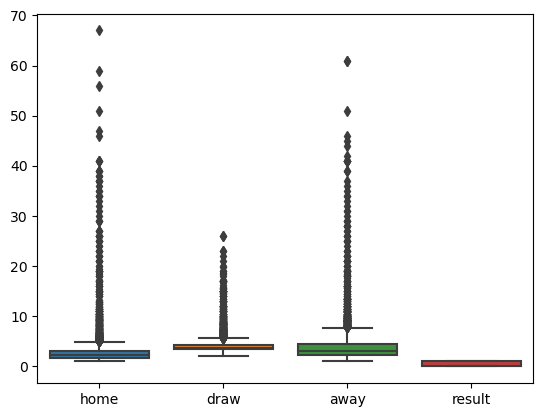

In [21]:
sns.boxplot(data=df)

__<h4>Removal of Outliers</h4>__

<AxesSubplot:>

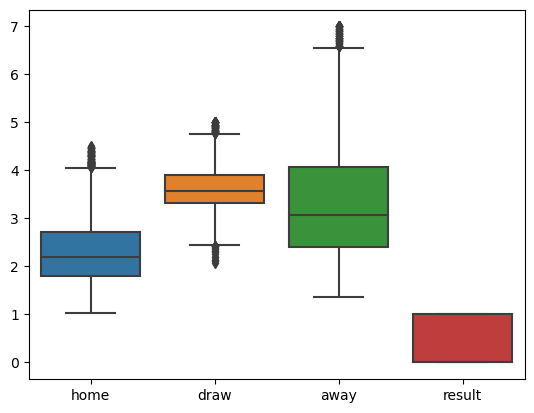

In [22]:
df.home=np.where(df.home>4.5,np.nan, df.home)
df.draw=np.where(df.draw>5,np.nan, df.draw)
df.away=np.where(df.away>7,np.nan, df.away)
df2=df.dropna()
df=df2
sns.boxplot(data=df2)

<h2>MODEL DEVELOPMENT</h2>

In [23]:
from sklearn.model_selection import train_test_split

X=df.drop('result', axis=1)
y=df['result']

col_names=X.columns
#standardization
#X=MinMaxScaler().fit_transform(X)

x_train, x_test, y_train, y_test=train_test_split(X,y,test_size=0.3,random_state=42)

__<h2>RANDOM FOREST</h2>__

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
model_rf=RandomForestClassifier(n_jobs=-1,random_state=0)

model_rf.fit(x_train,y_train)

y_pred=model_rf.predict(x_test)

print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.5243342516069789
              precision    recall  f1-score   support

           0       0.57      0.63      0.60       607
           1       0.46      0.39      0.42       482

    accuracy                           0.52      1089
   macro avg       0.51      0.51      0.51      1089
weighted avg       0.52      0.52      0.52      1089



__<h3>CROSS VALIDATION ON THE RANDOM MODEL</h3>__
The purpose is to see how the model performs on unseen data

In [25]:
from sklearn.model_selection import cross_val_score
accuracies=cross_val_score(estimator=model_rf, X=x_train, y=y_train, cv=10, n_jobs=-1)
accuracies

array([0.54117647, 0.47637795, 0.53149606, 0.45275591, 0.53543307,
       0.54724409, 0.48818898, 0.51574803, 0.54724409, 0.48031496])

__<h2>ADA_BOOST</h2>__

In [26]:
from sklearn.ensemble import AdaBoostClassifier

model_ada=AdaBoostClassifier(base_estimator=model_rf, random_state=0, n_estimators=100, 
                             learning_rate=0.5)

model_ada.fit(x_train,y_train)
y_pred=model_ada.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.5068870523415978
              precision    recall  f1-score   support

           0       0.55      0.63      0.59       607
           1       0.43      0.35      0.38       482

    accuracy                           0.51      1089
   macro avg       0.49      0.49      0.49      1089
weighted avg       0.50      0.51      0.50      1089



__<h3>TESTING BOTH MODELS ON NEW DATA</h3>__

In [27]:
df2=pd.read_csv('/Users/ERIA/Desktop/test_data2.csv')
df2.dropna(inplace=True)
df2=df2.astype('float')
df2.result=df2.result.astype('int')
df2

,home,draw,away,result
0,2.78,3.48,2.33,0
1,3.50,3.44,2.27,0
2,2.82,3.24,2.50,0
3,3.08,2.43,2.80,1
4,2.94,3.50,2.22,0
5,2.40,3.44,2.75,0
6,2.03,3.20,3.92,1
7,2.15,3.46,2.96,1
8,2.41,3.15,3.30,1
9,3.34,3.46,2.07,0


In [28]:
x_test2=df2.drop('result', axis=1)

In [29]:
y_pred2=model_rf.predict(x_test2)
print('actual_values ---> ',list(np.array(df2.result)))
print('predicted_values ->',list(y_pred2))


actual_values --->  [0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
predicted_values -> [0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]


In [30]:
y_pred2=model_ada.predict(x_test2)
print('actual_values ---> ',list(np.array(df2.result)))
print('predicted_values ->',list(y_pred2))


actual_values --->  [0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
predicted_values -> [0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]


Adaptive boosting nailed 11 of 16 while random forest also correctly predicted 10 of 16 results